In [80]:
# Packages

#pip install -U sentence-transformers
from termcolor import colored
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import string
import regex as re
import zipfile
import gc
from scipy.stats import boxcox
import sys 
from collections import Counter 
from tqdm import tqdm 
import pandas as pd 
import numpy as np 
import warnings, math
from termcolor import colored
import pickle
import string
from sklearn.metrics.pairwise import cosine_similarity

# for eval
from sklearn.model_selection import train_test_split
import random


# for SVD
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
pd.set_option('display.float_format','{:.5f}'.format)

# for EMB
#from sentence_transformers import SentenceTransformer, util
import scipy
from sklearn import preprocessing 

# for TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from sklearn import preprocessing 

# for creating a network
from sklearn.cluster import KMeans 

In [81]:
DF_PATH = r'D:\Papers\Paper 3 - Recommender Systems\Recommender-systems\Files\Oct_Forth_projectType.csv'
df = pd.read_csv(DF_PATH)

PROJECTS_DF_PATH = r"D:\Papers\Paper 3 - Recommender Systems\Recommender-systems\Files\projects.csv"
projects_df = pd.read_csv(PROJECTS_DF_PATH)

EXTERNAL_DF_PATH = r"D:\Papers\Paper 3 - Recommender Systems\Recommender-systems\Files\zip_code_database_enterprise.csv"
ext_features = pd.read_csv(EXTERNAL_DF_PATH)


C:\Users\Lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [82]:
ext_features.columns

Index(['zip', 'type', 'decommissioned', 'primary_city', 'acceptable_cities',
       'unacceptable_cities', 'state', 'county', 'timezone', 'area_codes',
       'world_region', 'country', 'approximate_latitude',
       'approximate_longitude', 'population_center_latitude',
       'population_center_longitude', 'polygon_offset_latitude',
       'polygon_offset_longitude', 'internal_point_latitude',
       'internal_point_longitude', 'latitude_min', 'latitude_max',
       'longitude_min', 'longitude_max', 'area_land', 'area_water',
       'housing_count', 'irs_estimated_households_2015',
       'irs_estimated_households_2014', 'irs_estimated_households_2013',
       'irs_estimated_households_2012', 'irs_estimated_households_2011',
       'irs_estimated_households_2010', 'irs_estimated_households_2009',
       'irs_estimated_households_2008', 'irs_estimated_households_2007',
       'irs_estimated_households_2006', 'irs_estimated_households_2005',
       'acs_estimated_households_2016', 'acs

In [83]:
# changing zips to strings

ext_features.loc[:, 'zip'] = ext_features.loc[:, 'zip'].astype(float).astype(int).astype(str)
df.loc[:, 'Donor Zip'] = df.loc[:, 'Donor Zip'].astype(float).astype(int).astype(str)

In [84]:
# calculate the length of zips
df.loc[:, 'len_zip'] = df['Donor Zip'].apply(lambda x: len(x))
ext_features.loc[:, 'len_zip'] = ext_features['zip'].apply(lambda x: len(x))

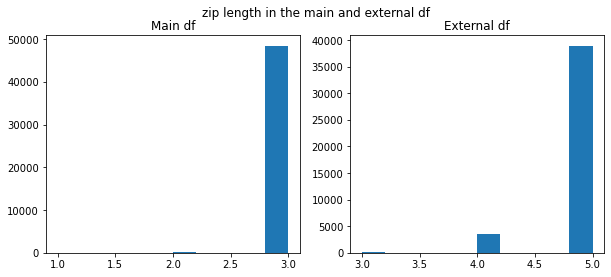

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4));

fig.suptitle('zip length in the main and external df')
ax1.hist(df.loc[:, 'len_zip'], );
ax2.hist(ext_features.loc[:, 'len_zip']);

ax1.title.set_text('Main df')
ax2.title.set_text('External df')

In [86]:
# due to security and the privacy of users, in the main df we have only the first three digits
# of the users

ext_features['zip_first_three_digits'] = ext_features['zip'].apply(lambda x:x[:3])
ext_features.drop(columns=['zip'], inplace=True)

df.rename(columns={'Donor Zip': 'zip_first_three_digits'}, inplace=True)

In [87]:
selected_features = ['zip_first_three_digits',
                    'population_count', 'housing_count', 
                    'total_male_population', 'total_female_population',
                    'median_household_income', 'median_earnings_past_year',
                    'percent_population_in_poverty',

                    'pop_under_10', 'pop_10_to_19', 'pop_20_to_29', 'pop_30_to_39',
                    'pop_40_to_49', 'pop_50_to_59', 'pop_60_to_69', 'pop_70_to_79',
                    'pop_80_plus',

                    'percent_high_school_graduate', 'percent_bachelors_degree',
                    'percent_graduate_degree',

                    'white', 'black_or_african_american',
                    'american_indian_or_alaskan_native', 'asian',
                    'native_hawaiian_and_other_pacific_islander', 'other_race',
                    'two_or_more_races', 
                    ]

ext_features = ext_features.loc[:, selected_features]#.groupby(['zip']).mean().reset_index()


In [88]:
ext_features.dropna(inplace=True)
ext_features.reset_index(drop=True, inplace=True)

In [89]:
weighted_mean = lambda x: np.average(x, weights=ext_features.loc[x.index, 'population_count'])


ext_features_agg = ext_features.groupby(by=['zip_first_three_digits']).agg(
    
    population_count=('population_count', 'sum'),
    housing_count=('housing_count', 'sum'),
    total_male_population=('total_male_population', 'sum'),
    total_female_population=('total_female_population', 'sum'),
    white=('white', 'sum'),
    black_or_african_american=('black_or_african_american', 'sum'),
    american_indian_or_alaskan_native=('american_indian_or_alaskan_native', 'sum'),
    asian=('asian', 'sum'),
    native_hawaiian_and_other_pacific_islander=('native_hawaiian_and_other_pacific_islander', 'sum'),
    other_race=('other_race', 'sum'),
    two_or_more_races=('two_or_more_races', 'sum'),

    

    median_household_income=('median_household_income', weighted_mean),
    percent_population_in_poverty=('percent_population_in_poverty', weighted_mean),
    median_earnings_past_year=('median_earnings_past_year', weighted_mean),
    percent_high_school_graduate=('percent_high_school_graduate', weighted_mean),	
    percent_bachelors_degree=('percent_bachelors_degree', weighted_mean),	
    percent_graduate_degree=('percent_graduate_degree', weighted_mean),

    pop_under_10=('pop_under_10', 'mean'),
    pop_10_to_19=('pop_10_to_19', 'mean'),	
    pop_20_to_29=('pop_20_to_29', 'mean'),
    pop_30_to_39=('pop_30_to_39', 'mean'),
    pop_40_to_49=('pop_40_to_49', 'mean'),
    pop_50_to_59=('pop_50_to_59', 'mean'),
    pop_60_to_69=('pop_60_to_69', 'mean'),
    pop_70_to_79=('pop_70_to_79', 'mean'),
    pop_80_plus=('pop_80_plus', 'mean'),
    ).reset_index()

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


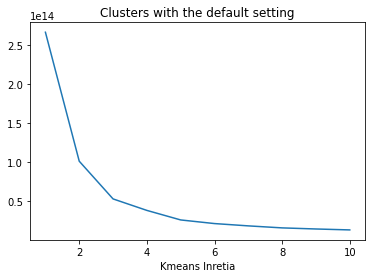

In [90]:
# which n for kmeans?

features = list(set(ext_features_agg.columns) - set(['zip_first_three_digits']))
inretia = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++',  max_iter=300, n_init=10,
                    random_state=0)
    kmeans.fit(ext_features_agg[features])
    inretia.append(kmeans.inertia_)
plt.plot(range(1,11),inretia)
plt.title('Clusters with the default setting')
plt.xlabel('Number of clusters')
plt.xlabel('Kmeans Inretia')
plt.show()

In [91]:
n=3
kmeans = KMeans(n_clusters=n, init='k-means++',  max_iter=300, n_init=10, random_state=0)
ext_features_agg['kmeans_cluster'] = kmeans.fit_predict(ext_features_agg[features])

In [93]:
EXT_FEATURES_PATH = 'D:\Papers\Paper 3 - Recommender Systems\Recommender-systems\Files\Graph_based\ext_features_agg.csv'
ext_features_agg.to_csv(EXT_FEATURES_PATH, index=False)

In [92]:
df_ = df[df['zip_first_three_digits'].isin(ext_features_agg['zip_first_three_digits'])]
df_.reset_index(inplace=True, drop=True)

print(f"Proportion of the dataset that is going to remain after merging = {len(df_)/len(df):.3f}")

Proportion of the dataset that is going to remain after merging = 0.998


In [95]:
NEW_DF_PATH = 'D:\Papers\Paper 3 - Recommender Systems\Recommender-systems\Files\Graph_based\Oct_28_df.csv'
df_.to_csv(NEW_DF_PATH , index=False)